# Using Fractional Cover (FC) to train a Random Forest (RF) Classifier for Land-cover Classification

The goal in this notebook is to train a classifier at the regional scale (Pacific) to get land-cover classification. The Pacific Islands face a critical lack of locally accurate land cover datasets. Existing global products are designed for continental or global scales and often fail to capture the nuanced land cover dynamics of the Pacific region. This leads to misclassification, underrepresentation of smaller land cover types, and unreliable data for local decision-making. The goal of our Random Forest classifier trained on fractional cover data and spectral data is to addresse this gap by providing a regionally tuned, high resolution land cover product specifically trained on Pacific island environments (e.g., Fiji, Cook Islands, Marshall Islands). 

In [1]:
import pandas as pd
import numpy as np 
import xarray as xr
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, classification_report, confusion_matrix
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import rasterio
from matplotlib.patches import Patch
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap

## 1. Data Preparation 

Data from Fiji, Cook Island, Marshall Island and Palaos were download to train a random forest that return land cover classification over the pacific region. We have for each island a shapefile containing point with the associated grountruth land cover label and position (lat, lon) and from the Sentinel-2 geomad, the RGB-NIR band were downloaded to compute the NDVI and NDWI and finally with .tif file with 3 bands for the annual fractionnal cover over each island. Then, we prepare the data using QGIS to have one dataset (shapefile) for each island containing for each point the following data :

- lat, lon
- Fractional Cover (bs : baresoil ; pv : photosynthetic vegetation ; npv : non-photosynthetic vegetation)
- NDVI
- NDWI
- NDBI (Normalized Difference Build Index)
- RGB-NIR (spectral bands)
- Label (class-id : 1. Forest ; 2. Cropland ; 3. Grassland ; 4. Buildup ; 5. Baresoil ; 6. Water ; 7. Mangroves)
- lulc (land-use, land-cover)
- Texture data (10 bands computed using Haralick Extraction Feature in QGIS --> GLCM)

The data are in the folder data, there 4 files (one per island).

In [13]:
# dataset path + loading

fiji_path = "./data/fiji.xlsx"
marshall_path = "./data/marshall.xlsx"
cook_path = "./data/cook.xlsx"
palaos_path = "./data/palaos.xlsx"

fj = pd.read_excel(fiji_path)
mh =  pd.read_excel(marshall_path)
ck =  pd.read_excel(cook_path)
pl =  pd.read_excel(palaos_path)

fj.head()

,fid,class_id,lulc,bs_pc_50,npv_pc_50,pv_pc_50,lon,lat,ndvi1,ndwi1,...,texture1,texture2,texture3,texture4,texture5,texture6,texture7,texture8,texture9,texture10
0,1,1,forest,9,0,87,178.325,-17.535,0.884564,-0.775417,...,4.84,0.1344,0,9.68,0.2976,1.021119,0.667973,0.1056,-0.868332,0.730750
1,2,1,forest,5,8,94,178.300,-17.535,0.823159,-0.711232,...,4.00,0.0000,0,8.00,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000
2,3,2,cropland,7,20,76,177.511,-17.551,0.804638,-0.734354,...,4.04,0.0384,0,8.08,0.0736,0.402179,0.296425,0.0384,-0.871069,0.503652
3,4,1,forest,2,10,89,177.651,-17.550,0.838690,-0.754122,...,4.08,0.0736,0,8.16,0.1344,0.634310,0.502801,0.0736,-0.849343,0.614172
4,5,2,cropland,8,31,60,177.664,-17.550,0.583125,-0.570485,...,3.98,0.0196,0,7.68,2.4576,0.056538,0.169415,0.0196,-0.879383,0.397971


In [14]:
def add_mean_std_per_lulc(df):
    group_stats = (
        df.groupby(['lulc'])['ndvi1']
        .agg(ndvi_mean='mean', ndvi_std='std')
        .reset_index()
    )
    
    df = df.merge(group_stats, on=['lulc'], how='left')
    return df 


fj = add_mean_std_per_lulc(fj)
mh = add_mean_std_per_lulc(mh)
ck = add_mean_std_per_lulc(ck)
pl = add_mean_std_per_lulc(pl)

In [15]:
# Create a table summarizing the lulc category distribution 

def count_lulc(df, island_name):
    counts = df["lulc"].value_counts().to_frame(name=island_name).T
    return counts

fj_counts = count_lulc(fj, "Fiji")
mh_counts = count_lulc(mh, "Marshall")
ck_counts = count_lulc(ck, "Cook")
pl_counts = count_lulc(pl, "Palaos")

summary = pd.concat([fj_counts, mh_counts, ck_counts, pl_counts], axis=0).fillna(0).astype(int)
summary["Total"] = summary.sum(axis=1)
summary = summary.sort_values(by="Total", ascending=False)

summary.head()

lulc,forest,grassland,mangroves,cropland,buildup,water,baresoil,Total
Fiji,3267,1520,683,558,137,39,15,6219
Cook,103,59,0,80,113,55,181,591
Palaos,72,77,18,63,42,36,183,491
Marshall,142,22,6,4,47,25,55,301


This summary table shows that there are a lot of data point in Fidji (on average 10 times more than in the other island) and that forest label is also over-represented. If we train a classifier directly on all the data, it will learn only charactheristics from this class and location and thus the classifier will be very bad on other class or other location. To avoid this, we need to balance the dataset before training the classifier.

### Deal with imbalance dataset

To build a good classifier that generalizes well across the Pacific, balancing data is important :

- Balancing between classes (so each LULC type is equally learned)
- Balancing between locations (so it doesn't overfit to any specific island)

But a minimum amount of data is needed in order to have a good classifier. Regarging the previous table, the less represented classes are water (155) and buildup (339). Based on this, the objective is to keep aroun 150-300 points per lulc. Finally to preserve spatial generalization, points from each island should be equally reprensented in each class.

I set manually : 

- Forest : Fiji : 80 ; Cook : 75 ; Palaos : 70 ; Marshall : 75 = 300
- Grassland : Fiji : 150 ; Cook : 59 ; Palaos : 77 ; Marshall : 22 = 308
- Mangroves : Fiji : 180 ; Cook : 0 ; Palaos : 18 ; Marshall : 6 = 204
- Cropland : Fiji : 150 ; Cook : 80 ; Palaos : 63 ; Marshall : 4 = 300
- Buildup : Fiji : 110 ; Cook : 110 ; Palaos : 40 ; Marshall : 40 = 300
- Water : Fiji : 39 ; Cook : 55 ; Palaos : 36 ; Marshall : 25 = 155
- Baresoil : Fiji : 15 ; Cook : 115 ; Palaos : 115 ; Marshall : 55 = 300

Following this distribution, the RF would be trained on 1867 data points.

In [53]:
random.seed(42)

sampling_plan = {
    "forest":     {"Fiji": 80,  "Cook": 75,  "Palaos": 70,  "Marshall": 75},
    "grassland":  {"Fiji": 140, "Cook": 59,  "Palaos": 77,  "Marshall": 22},
    "mangroves":  {"Fiji": 180, "Cook": 0,   "Palaos": 18,  "Marshall": 6},
    "cropland":   {"Fiji": 155, "Cook": 80,  "Palaos": 63,  "Marshall": 4},
    "buildup":    {"Fiji": 110, "Cook": 110, "Palaos": 40,  "Marshall": 40},
    "water":      {"Fiji": 39,  "Cook": 55,  "Palaos": 36,  "Marshall": 25},
    "baresoil":   {"Fiji": 15,  "Cook": 115, "Palaos": 115, "Marshall": 55}
}

island_dfs = {
    "Fiji": fj,
    "Cook": ck,
    "Palaos": pl,
    "Marshall": mh
}


samples = []


for lulc_class, island_counts in sampling_plan.items():
    for island, n_points in island_counts.items():
        if n_points == 0:
            continue
        df = island_dfs[island]
        df_filtered = df[df["lulc"] == lulc_class]

        if len(df_filtered) < n_points:
            raise ValueError(f"Not enough data for {lulc_class} in {island} (needed {n_points}, available {len(df_filtered)})")

        # Convert to list of rows (dicts), sample with random
        filtered_list = df_filtered.to_dict(orient="records")
        selected = random.sample(filtered_list, n_points)

        # Reconvert to DataFrame and add island info
        selected_df = pd.DataFrame(selected)
        selected_df["island"] = island
        samples.append(selected_df)

# Concatenate all sampled rows
train_df = pd.concat(samples, ignore_index=True)

# Check result
print("Final shape:", train_df.shape)
print("Class counts:\n", train_df["lulc"].value_counts())
print("Island counts:\n", train_df["island"].value_counts())


Final shape: (1859, 30)
Class counts:
 lulc
cropland     302
forest       300
buildup      300
baresoil     300
grassland    298
mangroves    204
water        155
Name: count, dtype: int64
Island counts:
 island
Fiji        719
Cook        494
Palaos      419
Marshall    227
Name: count, dtype: int64


In [54]:
train_df = train_df.drop(columns=['fid'])
df = train_df.sample(frac=1).reset_index(drop=True)
df.head()

,class_id,lulc,bs_pc_50,npv_pc_50,pv_pc_50,lon,lat,ndvi1,ndwi1,red1,...,texture4,texture5,texture6,texture7,texture8,texture9,texture10,ndvi_mean,ndvi_std,island
0,2,cropland,6,7,95,178.840000,-16.884000,0.867182,-0.759773,309.0,...,8.72,0.6816,1.478845,0.667973,0.1056,-0.630544,0.749223,0.760867,0.101747,Fiji
1,5,baresoil,0,0,63,171.379000,7.086000,-0.001955,0.085125,1025.0,...,0.00,0.0000,0.000000,0.738341,0.1204,-0.705497,0.779869,0.393956,0.251362,Marshall
2,5,baresoil,19,79,7,134.581000,7.365000,0.087533,-0.165657,2924.0,...,0.00,0.0000,0.000000,1.013557,0.1924,-0.880568,0.835601,0.336773,0.237276,Palaos
3,7,mangroves,16,0,100,178.248000,-17.376000,0.869880,-0.757246,270.0,...,6.68,11.4176,1.118581,0.906565,0.1600,-0.776928,0.818722,0.864441,0.069812,Fiji
4,6,water,43,24,32,-159.774428,-21.206983,0.303905,-0.302173,820.0,...,0.00,0.0000,0.000000,0.502801,0.0736,-0.849343,0.614172,0.525732,0.157282,Cook


In [55]:
# save the training dataset
df.to_excel('./data/training_data.xlsx')

In [56]:
# Create geometry column from lon/lat and save shp
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
gdf.to_file("./data/training_data.shp", driver="ESRI Shapefile")

## 2. Training RF Classifier

Initial training was performed using only Fractional Cover (FC) features. While the model learned general patterns, it failed to capture class-specific characteristics, resulting in low accuracy (~55%). To improve performance, spectral features (RGB bands) and vegetation/water indices (NDVI, NDWI) were added. This enriched the feature space with reflectance-based and moisture-related information, increasing accuracy to ~65%. However, the model still struggled to distinguish cropland, grassland, and forest—likely due to their spectral similarity.

To better capture spatial context, NDVI texture features were introduced using GLCM (Haralick features computed in QGIS). A [study](https://www.tandfonline.com/doi/full/10.1080/01431161.2016.1278314) suggests GLCM mean is most effective for classification, with contrast and entropy adding value in edge-rich or detailed contexts. Since band 1 appears to represent the mean, it was retained as texture1. A PCA-based reduction of all texture bands was tested but performed poorly—likely due to loss of spatial nuance—so only texture1 was kept.

Vegetation indices such as EVI and SAVI were also tested to better discriminate dense versus sparse vegetation. However, their inclusion led to misclassification, especially overprediction of cropland, suggesting feature redundancy or class confusion. NDBI, intended to improve separation of bare soil, lead to more forest pixel classify as baresoil or cropland but increase overall performance.

Alternative classifiers (XGBoost, SVM) and ensemble stacking were tested but underperformed compared to Random Forest, possibly due to the small or imbalanced training dataset.

Finally, the NDVI class-wise mean per island (ndvi_mean) was added. While this greatly boosted accuracy (~96%), it dominated feature importance, causing overfitting by allowing the model to learn class identity rather than general patterns.

In [57]:
# PCA on the 10 bands of texture to keep only the main information
texture_cols = ['texture1', 'texture2', 'texture3', 'texture4', 'texture5',
                'texture6', 'texture7', 'texture8', 'texture9', 'texture10']

# Standardize texture features
scaler = StandardScaler()
textures_scaled = scaler.fit_transform(df[texture_cols])

pca = PCA(n_components=3)
pca_components = pca.fit_transform(textures_scaled)

df['pca_texture1'] = pca_components[:, 0]
df['pca_texture2'] = pca_components[:, 1]

# Analyze feature importance per principal component
pca_df = pd.DataFrame(pca.components_, columns=texture_cols, index=['PC1', 'PC2', 'PC3'])
print(" PCA Component - importance of each texture variable:\n")
print(pca_df.T.sort_values(by='PC1', ascending=False))  # For PC1



 PCA Component - importance of each texture variable:

                PC1       PC2           PC3
texture7   0.422447  0.078792 -8.919989e-02
texture10  0.407619  0.165046 -1.416095e-01
texture8   0.403487  0.008989 -2.358343e-02
texture2   0.365535 -0.021641  1.756451e-01
texture5   0.242482  0.066423  8.990771e-01
texture6   0.174177  0.615308 -1.110643e-01
texture3   0.000000  0.000000  2.775558e-17
texture1  -0.247823  0.563322  1.334745e-01
texture4  -0.313094  0.472898  6.739093e-02
texture9  -0.332248 -0.204993  3.123312e-01


In [76]:
# Select Features and Labels 
features = df[['bs_pc_50', 'npv_pc_50', 'pv_pc_50', 'ndvi1', 'ndwi1', 'red1', 'green1', 'blue1', 'texture1', 'ndbi1']] #'nir1', 'savi', 'evi',  'ndbi1', 'ndvi_mean', 'ndvi_std', 'pca_texture1'...

labels = df['class_id']

# Train/Test Split 
X_train, X_val, y_train, y_val = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

# Train Random Forest Classifier 
rf = RandomForestClassifier(n_estimators=500, random_state=42, class_weight = 'balanced')
rf.fit(X_train, y_train)

# Make Predictions 
y_pred = rf.predict(X_val)

# Performance  Metrics
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='weighted')
kappa = cohen_kappa_score(y_val, y_pred)
report = classification_report(y_val, y_pred)


# Results 
print("Random Forest Classifier Performance")
print(f"Accuracy: {accuracy:.2%}")
print(f"Weighted F1-score: {f1:.2%}")
print(f"Cohen's Kappa: {kappa:.3f}")
print("\nClassification Report:\n", report)


Random Forest Classifier Performance
Accuracy: 76.08%
Weighted F1-score: 76.18%
Cohen's Kappa: 0.718

Classification Report:
               precision    recall  f1-score   support

           1       0.73      0.90      0.81        60
           2       0.64      0.72      0.68        60
           3       0.73      0.63      0.68        60
           4       0.71      0.70      0.71        60
           5       0.79      0.80      0.79        60
           6       0.96      0.84      0.90        31
           7       1.00      0.78      0.88        41

    accuracy                           0.76       372
   macro avg       0.79      0.77      0.78       372
weighted avg       0.77      0.76      0.76       372



In [77]:
# Get Feature Importances
importances = rf.feature_importances_
feature_names = features.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print Table
print("\nFeature Importances:")
print(importance_df)


Feature Importances:
     Feature  Importance
9      ndbi1    0.188353
4      ndwi1    0.121862
5       red1    0.121547
3      ndvi1    0.105973
7      blue1    0.092800
6     green1    0.087253
8   texture1    0.086911
2   pv_pc_50    0.076212
0   bs_pc_50    0.059573
1  npv_pc_50    0.059514


## 3. Testing and Show Results

In [78]:
test_path = './data/fiji_test.xlsx'
fiji_test = pd.read_excel(test_path)
fiji_test = add_mean_std_per_lulc(fiji_test)
fiji_test.head()

,fid,class_id,lulc,lon,lat,bs_pc_50,npv_pc_50,pv_pc_50,ndvi1,ndwi1,...,texture3,texture4,texture5,texture6,texture7,texture8,texture9,texture10,ndvi_mean,ndvi_std
0,4884,2,cropland,179.880846,-16.189437,5,25,67,0.687194,-0.666582,...,0,8.0,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.729905,0.101414
1,4889,3,grassland,179.691789,-16.204109,3,10,92,0.786174,-0.655252,...,0,8.0,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.775418,0.106297
2,4890,3,grassland,179.868409,-16.201796,4,27,63,0.615594,-0.651147,...,0,8.0,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.775418,0.106297
3,4891,3,grassland,179.881023,-16.201625,3,8,88,0.784103,-0.682975,...,0,8.0,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.775418,0.106297
4,4892,1,forest,179.893638,-16.201454,8,8,88,0.881146,-0.780438,...,0,9.8,0.16,0.721928,0.589735,0.09,-0.835978,0.647535,0.839017,0.060486


In [79]:
texture_cols = ['texture1', 'texture2', 'texture3', 'texture4', 'texture5',
                'texture6', 'texture7', 'texture8', 'texture9', 'texture10']


scaler = StandardScaler()
textures_scaled = scaler.fit_transform(fiji_test[texture_cols])


pca = PCA(n_components=3)
pca_components = pca.fit_transform(textures_scaled)

# Step 4: Add PCA components to df
fiji_test['pca_texture1'] = pca_components[:, 0]
fiji_test['pca_texture2'] = pca_components[:, 1]

In [80]:
X_test = fiji_test[['bs_pc_50', 'npv_pc_50', 'pv_pc_50', 'ndvi1', 'ndwi1', 'red1', 'green1', 'blue1', 'texture1', 'ndbi1']] #'nir1', 'savi', 'evi',  'ndbi1', 'ndvi_mean', 'ndvi_std', 'pca_texture1'...

# Predict classes with trained model
fiji_test['predicted_class'] = rf.predict(X_test)
fiji_test.head()

,fid,class_id,lulc,lon,lat,bs_pc_50,npv_pc_50,pv_pc_50,ndvi1,ndwi1,...,texture6,texture7,texture8,texture9,texture10,ndvi_mean,ndvi_std,pca_texture1,pca_texture2,predicted_class
0,4884,2,cropland,179.880846,-16.189437,5,25,67,0.687194,-0.666582,...,0.000000,0.000000,0.00,0.000000,0.000000,0.729905,0.101414,-1.924824,-0.211290,2
1,4889,3,grassland,179.691789,-16.204109,3,10,92,0.786174,-0.655252,...,0.000000,0.000000,0.00,0.000000,0.000000,0.775418,0.106297,-1.924824,-0.211290,3
2,4890,3,grassland,179.868409,-16.201796,4,27,63,0.615594,-0.651147,...,0.000000,0.000000,0.00,0.000000,0.000000,0.775418,0.106297,-1.924824,-0.211290,2
3,4891,3,grassland,179.881023,-16.201625,3,8,88,0.784103,-0.682975,...,0.000000,0.000000,0.00,0.000000,0.000000,0.775418,0.106297,-1.924824,-0.211290,5
4,4892,1,forest,179.893638,-16.201454,8,8,88,0.881146,-0.780438,...,0.721928,0.589735,0.09,-0.835978,0.647535,0.839017,0.060486,2.402470,1.800794,1


In [81]:
# True and predicted labels
y_true = fiji_test['class_id']
y_pred = fiji_test['predicted_class']

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
kappa = cohen_kappa_score(y_true, y_pred)

# Display results
print("Test Set Performance")
print(f"Accuracy: {accuracy:.2%}")
print(f"Weighted F1-score: {f1:.2%}")
print(f"Cohen's Kappa: {kappa:.3f}")


Test Set Performance
Accuracy: 62.98%
Weighted F1-score: 65.66%
Cohen's Kappa: 0.481


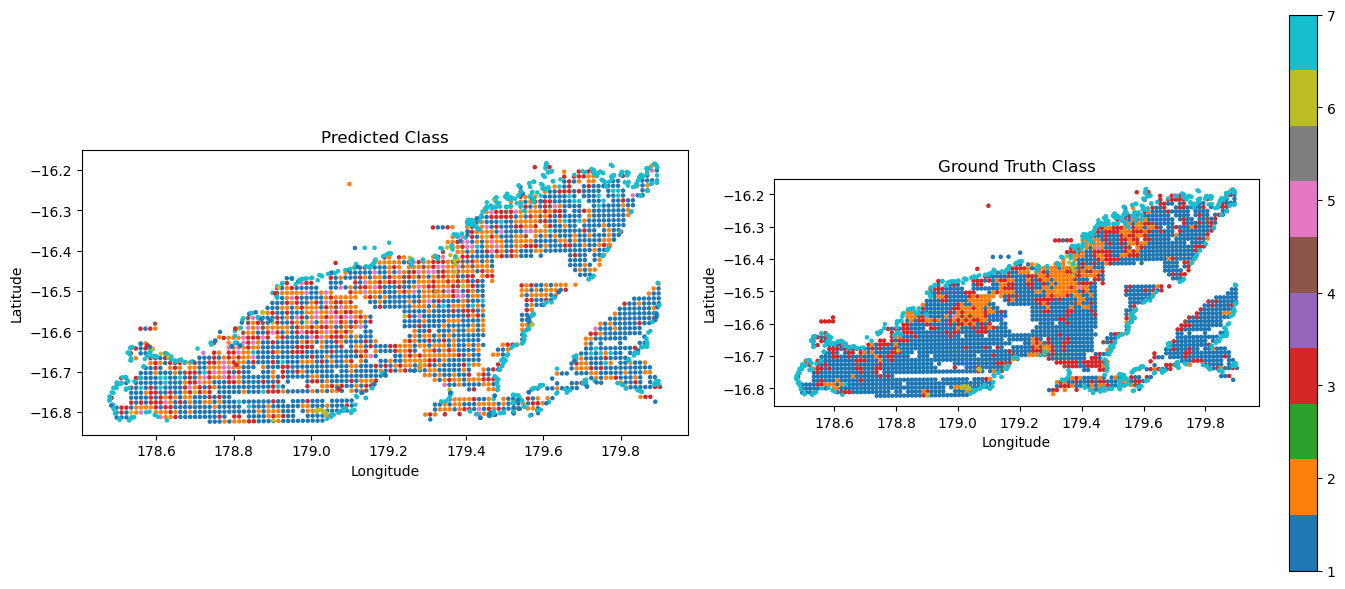

In [82]:
# Plot prediction and groundtruth 
geometry = [Point(xy) for xy in zip(fiji_test['lon'], fiji_test['lat'])]
gdf = gpd.GeoDataFrame(fiji_test, geometry=geometry, crs='EPSG:4326')


fig, axes = plt.subplots(1, 2, figsize=(14, 6))


gdf.plot(column='predicted_class', cmap='tab10', legend=False,
         ax=axes[0], markersize=5)
axes[0].set_title("Predicted Class")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
gdf.plot(column='class_id', cmap='tab10', legend=True,
         ax=axes[1], markersize=5)
axes[1].set_title("Ground Truth Class")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")

plt.tight_layout()
plt.show()


## 4. Comparison with Fractional Cover k-means clustering 

In [120]:
with rasterio.open('bs_pc_50_test.tif') as src:
    bs = src.read(1).astype('float32')
    meta = src.meta

with rasterio.open('pv_pc_50_test.tif') as src:
    pv = src.read(1).astype('float32')

with rasterio.open('npv_pc_50_test.tif') as src:
    npv = src.read(1).astype('float32')

def normalize_band(band, scale=255):
    return np.clip(band / scale, 0, 1)

bs_norm = normalize_band(bs, 255)
pv_norm = normalize_band(pv, 255)
npv_norm = normalize_band(npv, 255)

#  Stack into RGB 
rgb = np.dstack((bs_norm, pv_norm, npv_norm))
rgb = np.clip(rgb, 0, 1)


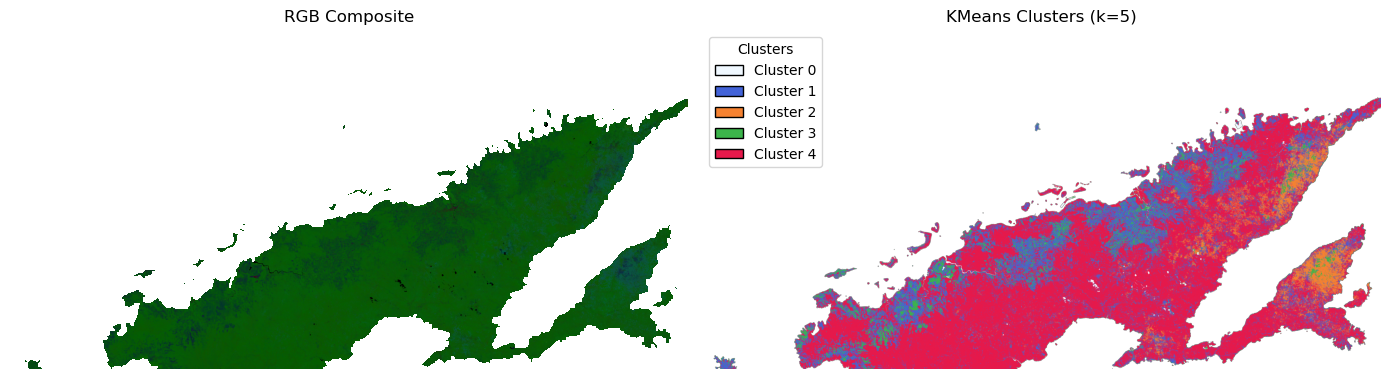

In [121]:
k = 5
h, w, c = rgb.shape

# Prepare Data for Clustering 
flat_rgb = rgb.reshape(-1, 3)
valid_mask = ~np.isnan(flat_rgb).any(axis=1)
rgb_valid = flat_rgb[valid_mask]

# KMeans Clustering
kmeans = KMeans(n_clusters=k, random_state=42)
labels = np.full(flat_rgb.shape[0], np.nan)
labels[valid_mask] = kmeans.fit_predict(rgb_valid)
label_img = labels.reshape(h, w)

# Plot RGB and Cluster Image 
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(rgb)
axes[0].set_title("RGB Composite")
axes[0].axis('off')

fixed_colors = [
    'aliceblue', '#4363d8', '#f58231', '#3cb44b', '#e6194b',
    '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe'
]
cluster_cmap = ListedColormap(fixed_colors[:k])

axes[1].imshow(label_img, cmap=cluster_cmap)
axes[1].set_title(f'KMeans Clusters (k={k})')
axes[1].axis('off')

legend_elements = [
    Patch(facecolor=cluster_cmap(i), edgecolor='black', label=f'Cluster {i}')
    for i in range(k)
]
axes[1].legend(handles=legend_elements, loc='upper left', title='Clusters')
plt.tight_layout()
plt.show()


## Prepare FC Temporal Data

In [3]:
from dea_tools.dask import create_local_dask_cluster
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/philippinel@spc.int/proxy/8787/status,
Dashboard: /user/philippinel@spc.int/proxy/8787/status,Workers: 1
Total threads: 8,Total memory: 57.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32949,Workers: 0
Dashboard: /user/philippinel@spc.int/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:40301,Total threads: 8
Dashboard: /user/philippinel@spc.int/proxy/35175/status,Memory: 57.21 GiB
Nanny: tcp://127.0.0.1:44373,


In [4]:
import sys
from pystac_client import Client
import depal_ck as dep
from odc.stac import load
from shapely import geometry
import geopandas as gpd
catalog = "https://stac.staging.digitalearthpacific.io"

client = Client.open(catalog)

collections = client.get_collections()

for collection in collections:
    print(collection.id)

dep_ls_wofs
dep_ls_fc
dep_ls_fc_summary_annual
dep_s2_geomad
dep_s1_mosaic
dep_ls_geomad
dep_s2_mangroves
dep_ls_wofs_summary_annual
dep_s2ls_intertidal
dep_ls_wofs_summary_alltime
dep_ls_wofl
dep_s1_geomad
dep_s2_sdb
dep_s2_ocm
dep_s2s1_mrd


In [5]:
"""
central_lat = -17.804934320313453
central_lon = 178.01258037660185
buffer = 1

lower_left = (central_lat - buffer, central_lon - buffer)
upper_right = (central_lat + buffer, central_lon + buffer)
bbox = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])
"""
fj= dep.get_country_admin_boundary("Fiji", "Division", "Central")
bbox = dep.get_bbox(fj)
bbox_geometry = geometry.box(*bbox)

gdf = gpd.GeoDataFrame({'geometry': [bbox_geometry]}, crs='EPSG:4326')
gdf.explore()

In [6]:
items = client.search(collections=["dep_ls_fc"], bbox=bbox).item_collection()
print(f"Found {len(items)} items")

Found 184 items


In [7]:
items = client.search(
    collections=["dep_ls_fc"],
    bbox=bbox,
).items()
chunks = dict(x=2048, y=2048)

# Load the data
data = load(items, chunks=chunks)
#data = data.resample(time="1QS").median("time", keep_attrs=True).compute()
#data = dep.do_coastal_clip(noumea, data, buffer=0.001)
print(data)

<xarray.Dataset> Size: 141GB
Dimensions:      (y: 13131, x: 14561, time: 184)
Coordinates:
  * y            (y) float64 105kB -1.802e+06 -1.802e+06 ... -2.195e+06
  * x            (x) float64 116kB 3.789e+05 3.789e+05 ... 8.157e+05 8.157e+05
    spatial_ref  int32 4B 32660
  * time         (time) datetime64[ns] 1kB 2024-01-02T22:12:54.439445 ... 202...
Data variables:
    bs           (time, y, x) uint8 35GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    pv           (time, y, x) uint8 35GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    ue           (time, y, x) uint8 35GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    npv          (time, y, x) uint8 35GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>


In [28]:
for i, time in enumerate(data.time.values):
    print(i)
    print(time)
    ds = data.sel(time=time)
    print(f"Region {time} x range: {ds.x.min().item()} to {ds.x.max().item()}")
    print(f"Region {time} y range: {ds.y.min().item()} to {ds.y.max().item()}")
    print("-"*40)

0
2024-01-02T22:12:54.439445000
Region 2024-01-02T22:12:54.439445000 x range: 378900.0 to 815700.0
Region 2024-01-02T22:12:54.439445000 y range: -2195400.0 to -1801500.0
----------------------------------------
1
2024-01-02T22:13:18.377081000
Region 2024-01-02T22:13:18.377081000 x range: 378900.0 to 815700.0
Region 2024-01-02T22:13:18.377081000 y range: -2195400.0 to -1801500.0
----------------------------------------
2
2024-01-03T22:06:52.669263000
Region 2024-01-03T22:06:52.669263000 x range: 378900.0 to 815700.0
Region 2024-01-03T22:06:52.669263000 y range: -2195400.0 to -1801500.0
----------------------------------------
3
2024-01-03T22:07:16.602638000
Region 2024-01-03T22:07:16.602638000 x range: 378900.0 to 815700.0
Region 2024-01-03T22:07:16.602638000 y range: -2195400.0 to -1801500.0
----------------------------------------
4
2024-01-10T22:13:04.670558000
Region 2024-01-10T22:13:04.670558000 x range: 378900.0 to 815700.0
Region 2024-01-10T22:13:04.670558000 y range: -2195400.0 

In [8]:
from sklearn.cluster import DBSCAN
from tqdm import tqdm

ds = data

# Define your time range
start_date = "2024-01-01"
end_date = "2024-04-30"

# Subset dataset based on time
ds_subset = ds.sel(time=slice(start_date, end_date))

# Keep track of the original time indices
original_time_indices = ds.get_index("time").get_indexer(ds_subset.time.values)

centroids = []

# Iterate through the subset time steps
for i in tqdm(range(len(ds_subset.time))):
    slice_i = ds_subset.isel(time=i)
    
    bs = slice_i['bs'].values
    mask = (bs != 0) & (bs != 255)

    if np.any(mask):
        y_coords, x_coords = np.where(mask)
        x_valid = ds_subset.x[x_coords]
        y_valid = ds_subset.y[y_coords]

        x_c = float(x_valid.mean())
        y_c = float(y_valid.mean())
        centroids.append((x_c, y_c))
    else:
        centroids.append((np.nan, np.nan))

centroids = np.array(centroids)

# Remove NaNs
valid_idx = ~np.isnan(centroids).any(axis=1)
valid_centroids = centroids[valid_idx]

# Cluster
clustering = DBSCAN(eps=50000, min_samples=2).fit(valid_centroids)

# Initialize full-length label array (for the subset)
subset_labels = np.full(len(ds_subset.time), fill_value=-1)
subset_labels[np.where(valid_idx)[0]] = clustering.labels_

# Map labels back to full time dimension
labels = np.full(len(ds.time), fill_value=-1)
labels[original_time_indices] = subset_labels

# Group time indices by region label
region_groups = {}
for label in np.unique(labels):
    if label == -1:
        continue
    region_groups[f"region_{label}"] = np.where(labels == label)[0]

# Done
print(f"Found {len(region_groups)} regions in the time range {start_date} to {end_date}.")


100%|██████████| 60/60 [02:18<00:00,  2.31s/it]

Found 4 regions in the time range 2024-01-01 to 2024-04-30.


In [15]:
def get_median_clean_fc(
    bbox,
    region_groups,
    timeframe="2024-01-01/2024-04-30",
    max_items=30,
    nodata_thresh=0.95,
    cloud_value=255
):
    items = client.search(
        collections=["dep_ls_fc"],
        bbox=bbox,
        datetime=timeframe,
        max_items=max_items
    ).items()

    data = load(items, chunks=dict(x=2048, y=2048))
    data = dep.do_coastal_clip(fj, data, buffer=0.001)

    print(f"Total images found: {data.time.size}")

    good_times = []

    for region_name, time_indices in region_groups.items():
        region_ds = ds.isel(time=time_indices)
        print(f"\n--- Processing {region_name} with {len(time_indices)} scenes ---")


        for t in region_ds.time.values:
            bs = region_ds['bs'].sel(time=t)
            invalid_bs = (bs == cloud_value).mean().compute().item()

            npv = region_ds['npv'].sel(time=t)
            invalid_npv = (npv == cloud_value).mean().compute().item()

            print(f"{t}  invalid_bs% = {invalid_bs:.3f} ; invalid_npv% = {invalid_npv:.3f}")

            if invalid_bs < nodata_thresh:
                good_times.append(t)

    if len(good_times) == 0:
        raise ValueError("No clean images found below threshold")

    print(f"Using {len(good_times)} images for median composite")


    clean = data.sel(time=good_times)
    # Compute final median composite
    final_mosaic = clean.median(dim="time", keep_attrs=True).compute()

    return final_mosaic


data = get_median_clean_fc(bbox, region_groups, timeframe="2024-01-01/2024-04-30", max_items=100, nodata_thresh=0.92, cloud_value=255)
print(data)


Total images found: 60

--- Processing region_0 with 15 scenes ---
2024-01-02T22:12:54.439445000  invalid_bs% = 0.905 ; invalid_npv% = 0.832
2024-01-10T22:13:04.670558000  invalid_bs% = 0.886 ; invalid_npv% = 0.886
2024-01-18T22:12:54.914093000  invalid_bs% = 0.924 ; invalid_npv% = 0.847
2024-01-26T22:13:03.150032000  invalid_bs% = 0.921 ; invalid_npv% = 0.827
2024-02-03T22:12:53.727127000  invalid_bs% = 0.913 ; invalid_npv% = 0.824
2024-02-11T22:13:05.806664000  invalid_bs% = 0.884 ; invalid_npv% = 0.857
2024-02-19T22:12:52.345976000  invalid_bs% = 0.921 ; invalid_npv% = 0.855
2024-02-27T22:12:56.649255000  invalid_bs% = 0.917 ; invalid_npv% = 0.837
2024-03-06T22:12:40.184909000  invalid_bs% = 0.937 ; invalid_npv% = 0.838
2024-03-14T22:12:57.917130000  invalid_bs% = 0.927 ; invalid_npv% = 0.832
2024-03-22T22:12:31.367126000  invalid_bs% = 0.922 ; invalid_npv% = 0.845
2024-03-30T22:12:49.142252000  invalid_bs% = 0.956 ; invalid_npv% = 0.825
2024-04-07T22:12:24.515615000  invalid_bs% = 

In [ ]:
def plot_fc_bands_and_rgb(ds):
    """
    ds = xarray.Dataset returned by get_latest_clean_fc()
    containing 'bs', 'pv', 'npv'
    """

    # Convert xarray → numpy
    bs  = ds['bs'].values
    pv  = ds['pv'].values
    npv = ds['npv'].values

    # Build RGB stack
    rgb = np.stack([bs, pv, npv], axis=-1).astype(np.float32)
    rgb = rgb / 255.0  # stretch 0-1 for display

    fig, axs = plt.subplots(1, 4, figsize=(20, 6))

    axs[0].imshow(bs, cmap='gray')
    axs[0].set_title("BS (Bare Soil)")
    axs[0].axis('off')

    axs[1].imshow(pv, cmap='gray')
    axs[1].set_title("PV (Green)")
    axs[1].axis('off')

    axs[2].imshow(npv, cmap='gray')
    axs[2].set_title("NPV (Brown)")
    axs[2].axis('off')

    axs[3].imshow(rgb)
    axs[3].set_title("RGB (BS/PV/NPV)")
    axs[3].axis('off')

    plt.tight_layout()
    plt.show()


# Example usage:
plot_fc_bands_and_rgb(final_data.sel('region'==2))


In [22]:
def get_per_region_median_fc(
    bbox,
    region_groups,
    timeframe="2024-01-01/2024-04-30",
    max_items=100
):
    # Load the data (includes lazy loading with Dask)
    items = client.search(
        collections=["dep_ls_fc"],
        bbox=bbox,
        datetime=timeframe,
        max_items=max_items
    ).items()

    data = load(items, chunks=dict(x=2048, y=2048))
    data = dep.do_coastal_clip(fj, data, buffer=0.001)

    print(f"Total images found: {data.time.size}")

    region_composites = []

    for region_name, time_indices in region_groups.items():
        if len(time_indices) == 0:
            print(f" Skipping {region_name}: no time indices")
            continue

        region_ds = data.isel(time=time_indices)

        print(f"\n Processing {region_name} with {len(time_indices)} scenes")
        median_composite = region_ds.median(dim="time", keep_attrs=True).compute()

        # Add region as coordinate (if stacking later)
        median_composite = median_composite.expand_dims(dim={"region": [region_name]})
        region_composites.append(median_composite)

    if not region_composites:
        raise ValueError("No region composites computed")

    # Concatenate all regional composites along a new 'region' dimension
    final_output = xr.combine_by_coords(region_composites, combine_attrs="override", join="outer")

    return final_output


final_data = get_per_region_median_fc(
    bbox=bbox,
    region_groups=region_groups,
    timeframe="2024-01-01/2024-04-30",
    max_items=100
)

print(final_data)

Total images found: 60

 Processing region_0 with 15 scenes

 Processing region_1 with 15 scenes

 Processing region_2 with 13 scenes

 Processing region_3 with 15 scenes
<xarray.Dataset> Size: 2GB
Dimensions:      (region: 4, y: 3881, x: 3541)
Coordinates:
  * region       (region) object 32B 'region_0' 'region_1' 'region_2' 'region_3'
  * y            (y) float64 31kB -1.922e+06 -1.922e+06 ... -2.039e+06
  * x            (x) float64 28kB 5.817e+05 5.818e+05 ... 6.879e+05 6.879e+05
    spatial_ref  int64 8B 0
Data variables:
    bs           (region, y, x) float64 440MB 255.0 255.0 255.0 ... 255.0 255.0
    pv           (region, y, x) float64 440MB 255.0 255.0 255.0 ... 255.0 255.0
    ue           (region, y, x) float64 440MB 255.0 255.0 255.0 ... 255.0 255.0
    npv          (region, y, x) float64 440MB 255.0 255.0 255.0 ... 255.0 255.0


In [23]:
for i, region_name in enumerate(final_data.region.values):
    ds = final_data.sel(region=region_name)
    print(f"Region {region_name} x range: {ds.x.min().item()} to {ds.x.max().item()}")
    print(f"Region {region_name} y range: {ds.y.min().item()} to {ds.y.max().item()}")
    print("-"*40)

Region region_0 x range: 581730.0 to 687930.0
Region region_0 y range: -2038590.0 to -1922190.0
----------------------------------------
Region region_1 x range: 581730.0 to 687930.0
Region region_1 y range: -2038590.0 to -1922190.0
----------------------------------------
Region region_2 x range: 581730.0 to 687930.0
Region region_2 y range: -2038590.0 to -1922190.0
----------------------------------------
Region region_3 x range: 581730.0 to 687930.0
Region region_3 y range: -2038590.0 to -1922190.0
----------------------------------------


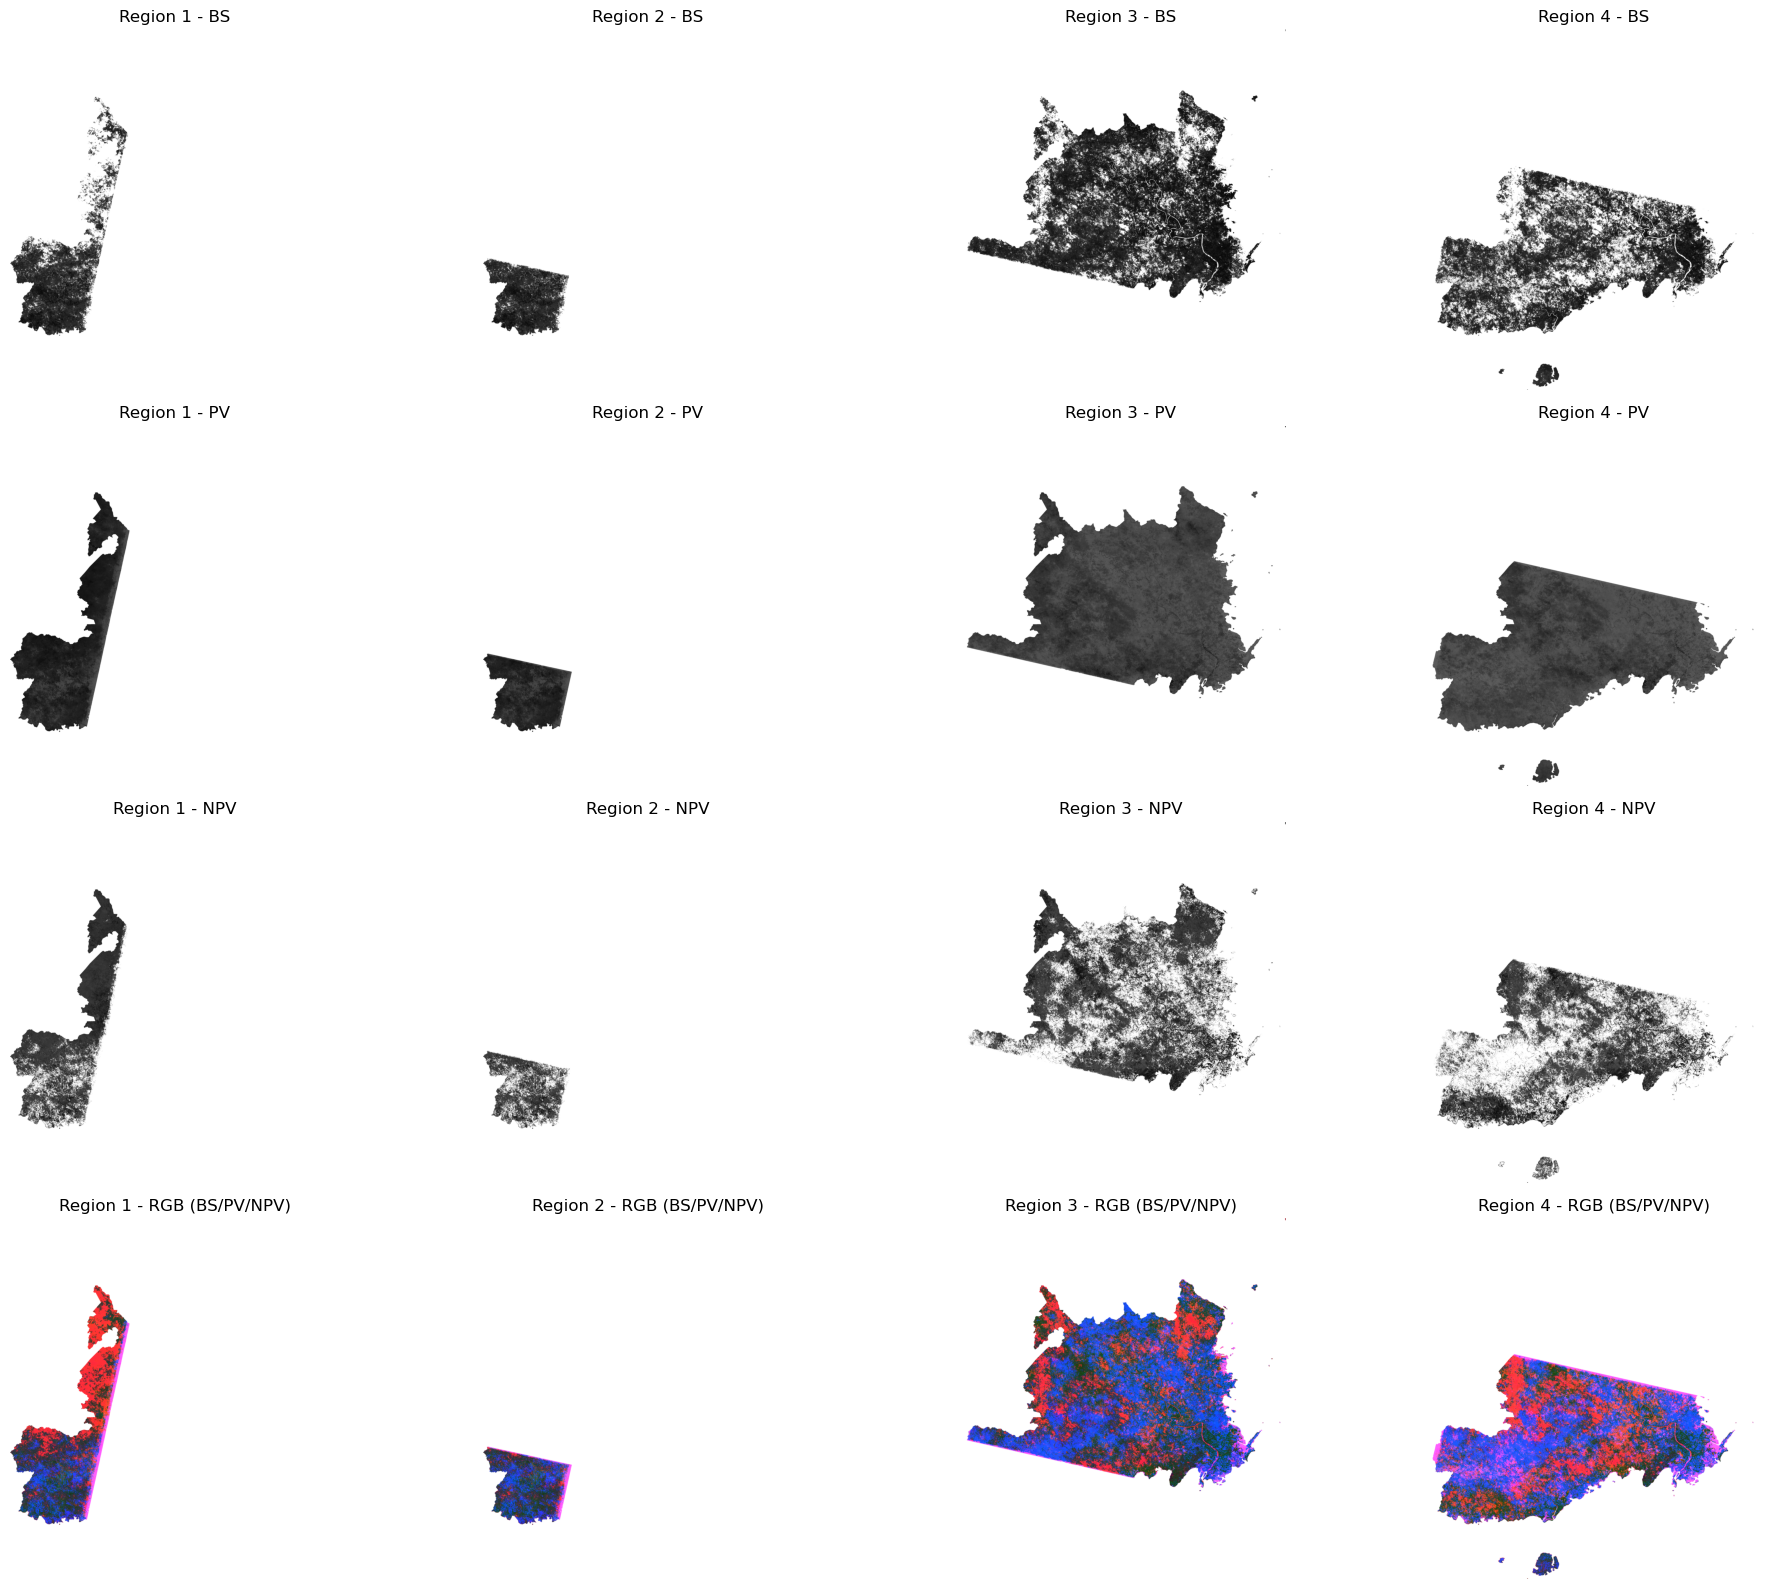

In [21]:
def plot_fc_bands_and_rgb(final_data):
    """
    Plots BS, PV, NPV, and RGB composite for all regions in final_data (4 regions).
    Assumes final_data is an xarray.Dataset with time, y, x dimensions.
    """

    num_regions = final_data.sizes['region']
    bands = ['bs', 'pv', 'npv']

    fig, axs = plt.subplots(4, num_regions, figsize=(5*num_regions, 16))

    for i in range(num_regions):
        ds = final_data.isel(region=i)

        # Convert xarray → numpy
        bs = ds['bs'].values
        pv = ds['pv'].values
        npv = ds['npv'].values

        # Build RGB
        rgb = np.stack([bs, pv, npv], axis=-1).astype(np.float32) / 255.0

        # Plot BS
        axs[0, i].imshow(bs, cmap='gray')
        axs[0, i].set_title(f"Region {i+1} - BS")
        axs[0, i].axis('off')

        # Plot PV
        axs[1, i].imshow(pv, cmap='gray')
        axs[1, i].set_title(f"Region {i+1} - PV")
        axs[1, i].axis('off')

        # Plot NPV
        axs[2, i].imshow(npv, cmap='gray')
        axs[2, i].set_title(f"Region {i+1} - NPV")
        axs[2, i].axis('off')

        # Plot RGB composite
        axs[3, i].imshow(rgb)
        axs[3, i].set_title(f"Region {i+1} - RGB (BS/PV/NPV)")
        axs[3, i].axis('off')

    plt.tight_layout()
    plt.show()
    
plot_fc_bands_and_rgb(final_data)

In [30]:
import rioxarray

final_data = final_data.rio.write_crs("EPSG:32660", inplace=True)  # Example UTM zone 60S

for region_name in final_data.region.values:
    ds_region = final_data.sel(region=region_name).squeeze(drop=True)
    
    # Export each variable as a band stack in one GeoTIFF, or separately:
    # Here save bs, pv, ue, npv as 4 bands in one tif:
    
    # Create DataArray with stacked bands
    bands = ds_region[['bs', 'pv', 'npv']].to_array(dim="band")
    # Assign band numbers or names (optional)
    bands = bands.rename({'band': 'band'})
    bands.rio.to_raster(f"{region_name}_median_composite.tif")


In [19]:
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Normalize to 0–255 and convert to uint8
def scale_to_uint8(arr):
    arr = np.clip(arr, 0, 255)
    return arr.astype(np.uint8)

# Extract and prepare bands
r = scale_to_uint8(data['bs'].values)
g = scale_to_uint8(data['pv'].values)
b = scale_to_uint8(data['npv'].values)

# Shape: (bands, rows, cols)
rgb_stack = np.stack([r, g, b], axis=0)

# Spatial resolution (assuming regular spacing)
res_x = float(data.x[1] - data.x[0])
res_y = float(data.y[1] - data.y[0])

# Affine transform (top-left origin)
transform = from_origin(
    west=float(data.x[0]),
    north=float(data.y[0]),
    xsize=res_x,
    ysize=-res_y  # y decreases downwards in arrays
)

# Define CRS: Pacific region, Southern Hemisphere
crs = "EPSG:32659"

# Save to GeoTIFF
with rasterio.open(
    "fc_composite.tif",
    "w",
    driver="GTiff",
    height=rgb_stack.shape[1],
    width=rgb_stack.shape[2],
    count=3,
    dtype=rasterio.uint8,
    crs=crs,
    transform=transform
) as dst:
    dst.write(rgb_stack[0], 1)  # Red
    dst.write(rgb_stack[1], 2)  # Green
    dst.write(rgb_stack[2], 3)  # Blue

print("Saved: landsat_rgb_composite.tif")


Saved: landsat_rgb_composite.tif
